# CAR PRICE PREDICTION

### *- Nancy Ruan, Monashree Sanil, Wei He*

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from scipy.stats import jarque_bera
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Let's load the data into a pandas dataframe
df = pd.read_csv("data.csv")

<div class="alert alert-block alert-warning"> 
First things first, let's see how many features and observations we have for predicting the price of a car.

In [4]:
print("Number of features:", df.shape[1] - 1)
print("Number of observations:", df.shape[0])

Number of features: 15
Number of observations: 11914


<div class="alert alert-block alert-warning">
We have 15 features to work with. The sample size seems to be good enough. Normality in car price and estimates may not creep in. But, we can investigate on this later using appropriate techniques and get concrete inferences. For now, we need to find out what all features do we have at hand to predict the price of a car and how many of them are numerical and how many are categorical.

In [5]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [6]:
df.dtypes

Make                  object
Model                 object
Year                   int64
Engine Fuel Type      object
Engine HP            float64
Engine Cylinders     float64
Transmission Type     object
Driven_Wheels         object
Number of Doors      float64
Market Category       object
Vehicle Size          object
Vehicle Style         object
highway MPG            int64
city mpg               int64
Popularity             int64
MSRP                   int64
dtype: object

<div class="alert alert-block alert-warning">
Using pratical understanding and looking at the data type, we can identify some of the categorical and numerical variables:
    <li>Categorical variables: Make, Model, Engine Fuel Type, Transmission Type, Driven_Wheels, Market Catgeory, Vehicle Size, Vehicle Style </li>
    <li>Numerical variables: Year, Engine HP, highway MPG, city mpg, Popularity</li>
Engine Cylinders, Number of Doors have numeric data types. But intuitively, we can infer that these would also be categorical variables. Let's confirm on our inferences about categorical variables.

In [7]:
# Make
df['Make'].value_counts(), len(df['Make'].unique())

(Chevrolet        1123
 Ford              881
 Volkswagen        809
 Toyota            746
 Dodge             626
 Nissan            558
 GMC               515
 Honda             449
 Mazda             423
 Cadillac          397
 Mercedes-Benz     353
 Suzuki            351
 BMW               334
 Infiniti          330
 Audi              328
 Hyundai           303
 Volvo             281
 Subaru            256
 Acura             252
 Kia               231
 Mitsubishi        213
 Lexus             202
 Buick             196
 Chrysler          187
 Pontiac           186
 Lincoln           164
 Oldsmobile        150
 Land Rover        143
 Porsche           136
 Saab              111
 Aston Martin       93
 Plymouth           82
 Bentley            74
 Ferrari            69
 FIAT               62
 Scion              60
 Maserati           58
 Lamborghini        52
 Rolls-Royce        31
 Lotus              29
 Tesla              18
 HUMMER             17
 Maybach            16
 Alfa Romeo

In [8]:
# Model
len(df.groupby("Model").filter(lambda x: len(x) < 10 )['Model'].unique())

505

<div class="alert alert-block alert-warning">
It looks like if we treat Model as categorical, we would have 914 categores which doesn't seem right. More than half of the model categories have less than 10 observations. Hence, we can say that 'Model' won't be a significant contributing feature for predicting the price. Making it categorical would lead to introduction of many dummy variables and this could lead to unecessary multicollinearity and noise. We will drop 'Model' feature from our data.

In [9]:
df = df.drop(columns = 'Model')
df.columns

Index(['Make', 'Year', 'Engine Fuel Type', 'Engine HP', 'Engine Cylinders',
       'Transmission Type', 'Driven_Wheels', 'Number of Doors',
       'Market Category', 'Vehicle Size', 'Vehicle Style', 'highway MPG',
       'city mpg', 'Popularity', 'MSRP'],
      dtype='object')

In [10]:
# Engine Fuel Type
df['Engine Fuel Type'].value_counts(), len(df['Engine Fuel Type'].unique())

(regular unleaded                                7172
 premium unleaded (required)                     2009
 premium unleaded (recommended)                  1523
 flex-fuel (unleaded/E85)                         899
 diesel                                           154
 electric                                          66
 flex-fuel (premium unleaded required/E85)         54
 flex-fuel (premium unleaded recommended/E85)      26
 flex-fuel (unleaded/natural gas)                   6
 natural gas                                        2
 Name: Engine Fuel Type, dtype: int64,
 11)

<div class="alert alert-block alert-warning">
We can club 'premium unleaded (required)', 'premium unleaded (recommended)' under one category 'premium'. Also, we can club all categories starting with flex-fuel under one category. 

In [11]:
df.loc[df['Engine Fuel Type'] != 'natural gas', 'Engine Fuel Type'] = df.loc[df['Engine Fuel Type'] != 'natural gas', 'Engine Fuel Type'].str.split(" ",expand = True)[0]
df['Engine Fuel Type'].value_counts(), len(df['Engine Fuel Type'].unique())

(regular        7172
 premium        3532
 flex-fuel       985
 diesel          154
 electric         66
 natural gas       2
 Name: Engine Fuel Type, dtype: int64,
 7)

In [12]:
# Transmission Type
df['Transmission Type'].value_counts(), len(df['Transmission Type'].unique())

(AUTOMATIC           8266
 MANUAL              2935
 AUTOMATED_MANUAL     626
 DIRECT_DRIVE          68
 UNKNOWN               19
 Name: Transmission Type, dtype: int64,
 5)

In [13]:
# Driven_Wheels
df['Driven_Wheels'].value_counts(), len(df['Driven_Wheels'].unique())

(front wheel drive    4787
 rear wheel drive     3371
 all wheel drive      2353
 four wheel drive     1403
 Name: Driven_Wheels, dtype: int64,
 4)

In [14]:
# Vehicle Size
df['Vehicle Size'].value_counts(), len(df['Vehicle Size'].unique())

(Compact    4764
 Midsize    4373
 Large      2777
 Name: Vehicle Size, dtype: int64,
 3)

In [15]:
# Vehicle Style
df['Vehicle Style'].value_counts(), len(df['Vehicle Style'].unique())

(Sedan                  3048
 4dr SUV                2488
 Coupe                  1211
 Convertible             793
 4dr Hatchback           702
 Crew Cab Pickup         681
 Extended Cab Pickup     623
 Wagon                   592
 2dr Hatchback           506
 Passenger Minivan       417
 Regular Cab Pickup      392
 2dr SUV                 138
 Passenger Van           128
 Cargo Van                95
 Cargo Minivan            71
 Convertible SUV          29
 Name: Vehicle Style, dtype: int64,
 16)

<div class="alert alert-block alert-warning">
There are too many unnecessary categories in this feature. Different categories based on the number of doors like '4dr SUV', '2dr SUV' is providing us redundant information that is already captured by the 'Number of Doors' feature. Similarly, we also have different categories based on the number of seats in the car. This information is also captured by 'Vehicle Size' feature. This can lead to multicollinearity amon the features. Hence, we can group such categories under one category.

In [18]:
def clean_vehicle_style(vehicle_style):
    vehicle_style = vehicle_style.lower().strip()
    if re.search(r'\b[0-9]dr\b', vehicle_style):
        return re.sub(r'\b[0-9]dr\b', "", vehicle_style).strip()
    elif re.search(r'\bregular\b|\bextended\b|\bcrew\b', vehicle_style):
        return re.sub(r'\bregular\b|\bextended\b|\bcrew\b', "", vehicle_style).strip()
    return vehicle_style     

In [19]:
df['Vehicle Style']=df['Vehicle Style'].apply(clean_vehicle_style)
df['Vehicle Style'].value_counts(), len(df['Vehicle Style'].unique())

(sedan                3048
 suv                  2626
 cab pickup           1696
 coupe                1211
 hatchback            1208
 convertible           793
 wagon                 592
 passenger minivan     417
 passenger van         128
 cargo van              95
 cargo minivan          71
 convertible suv        29
 Name: Vehicle Style, dtype: int64,
 12)

In [20]:
# Engine Cylinders
df['Engine Cylinders'].value_counts(), len(df['Engine Cylinders'].unique())

(4.0     4752
 6.0     4489
 8.0     2031
 12.0     230
 5.0      225
 10.0      68
 0.0       56
 3.0       30
 16.0       3
 Name: Engine Cylinders, dtype: int64,
 10)

In [21]:
# Number of Doors
df['Number of Doors'].value_counts(), len(df['Number of Doors'].unique())

(4.0    8353
 2.0    3160
 3.0     395
 Name: Number of Doors, dtype: int64,
 4)

In [22]:
# Market Category
df['Market Category'] = df['Market Category'].str.split(',')
df['Market Category'].explode().unique()

array(['Factory Tuner', 'Luxury', 'High-Performance', 'Performance',
       'Flex Fuel', nan, 'Hatchback', 'Hybrid', 'Diesel', 'Exotic',
       'Crossover'], dtype=object)

<div class="alert alert-block alert-warning">
We have overlapping categories in Market Category feature. Hence, we cannot use dummy variables for this categorical variable as it violates the assumption of categories being mututally exclusive. On exploding, we can see that there are categories like Flex Fuel, Hybrid, Hatchback etc. This kind of information is provided by other features like 'Vehicle Style', 'Engine Fuel Type' etc. Hence, the categories that can add information is whether the car is luxury or exotic.

In [23]:
def check(x):
    if type(x)!= list:
        return x
    elif "luxury" in [a.lower().strip() for a in x]:
        return "Luxury"
    elif "exotic" in [a.lower().strip() for a in x]:
        return "Exotic"
    else:
        return "Other"
        
df['Market Category'] = df['Market Category'].apply(check)

In [24]:
df['Market Category'].value_counts()

Other     4592
Luxury    3288
Exotic     292
Name: Market Category, dtype: int64

<div class="alert alert-block alert-warning">
Next, we need to check missing data. 

In [25]:
missing = df.isna().sum()
missing = (missing/len(df))*100
missing = missing.loc[missing > 0].sort_values(ascending=False)
missing

Market Category     31.408427
Engine HP            0.579151
Engine Cylinders     0.251805
Number of Doors      0.050361
Engine Fuel Type     0.025180
dtype: float64

<div class="alert alert-block alert-warning">
As very few observations are missing from 'Number of Doors', 'Engine Fuel Type', 'Engine Cylinders' and 'Engine HP', we can chose to ignore these observations. For 'Market Category' fetaure, we can replace missing values with a new category 'Unknown'.

In [26]:
df['Market Category'] = df['Market Category'].replace(np.nan, "Unknown")
df = df.dropna()
print("Number of observations in cleaned data:", df.shape[0])

Number of observations in cleaned data: 11812


<div class="alert alert-block alert-warning">
That's a good amount of data!
It is observed that 'Year' feature does not have any nonsensical value. Also, it makes more sense to transform 'Year' to indicate how many years it has been since the current year as we are concerned here about the selling price of the car.

In [27]:
df['Year'] = 2021 - df['Year']

In [28]:
df.dtypes

Make                  object
Year                   int64
Engine Fuel Type      object
Engine HP            float64
Engine Cylinders     float64
Transmission Type     object
Driven_Wheels         object
Number of Doors      float64
Market Category       object
Vehicle Size          object
Vehicle Style         object
highway MPG            int64
city mpg               int64
Popularity             int64
MSRP                   int64
dtype: object

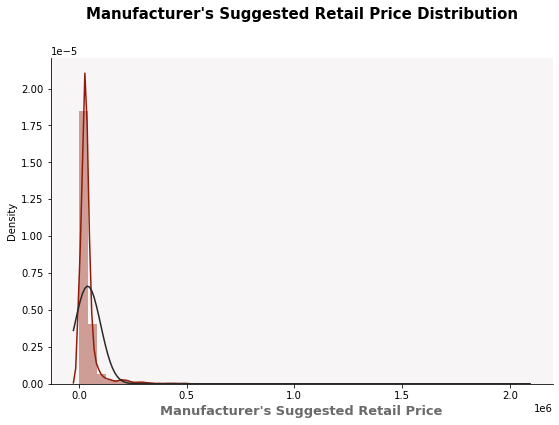

In [30]:
# MSRP Distirbution

fig, ax = plt.subplots(figsize=(9, 6))
sns.distplot(df['MSRP'], fit=norm, color = "#911B09")
ax.set_xlabel("Manufacturer's Suggested Retail Price", color='#6B6969', fontsize=13, weight = 'bold')
ax.set_title("Manufacturer's Suggested Retail Price Distribution",
             fontsize=15, weight='bold', x= 0.5, y = 1.1)
ax.set_facecolor('#F7F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [31]:
# Calculate percentiles for MSRP
print(df['MSRP'].max())
print(np.percentile(df['MSRP'],99.9))
print(np.percentile(df['MSRP'],95))
print(np.percentile(df['MSRP'],90))
print(np.percentile(df['MSRP'],80))
print(np.percentile(df['MSRP'],70))
print(np.percentile(df['MSRP'],60))
print(np.percentile(df['MSRP'],50))
print(np.percentile(df['MSRP'],40))
print(np.percentile(df['MSRP'],30))
print(np.percentile(df['MSRP'],20))
print(np.percentile(df['MSRP'],15))
print(np.percentile(df['MSRP'],13))
print(np.percentile(df['MSRP'],10))
print(df['MSRP'].min())

2065902
497650.0
107942.7499999999
64854.5
46350.0
38961.999999999985
33955.0
29970.0
26317.000000000004
22935.0
18372.000000000004
14337.599999999999
3553.29
2239.2000000000003
2000


<div class="alert alert-block alert-warning">
When we look at the distribution of MSRP, we see that there are some outliers in the dataset. The maximum value 2065902 and the minimum value 2000 different from each other very much. It might be extremely difficult to fit one model to that range of data. So, based on the investigation on percentile values, we decide to include 10000 < MSRP < 65000.

In [32]:
dfnew = df.loc[(df['MSRP'] > 10000) & (df['MSRP'] < 65000)]

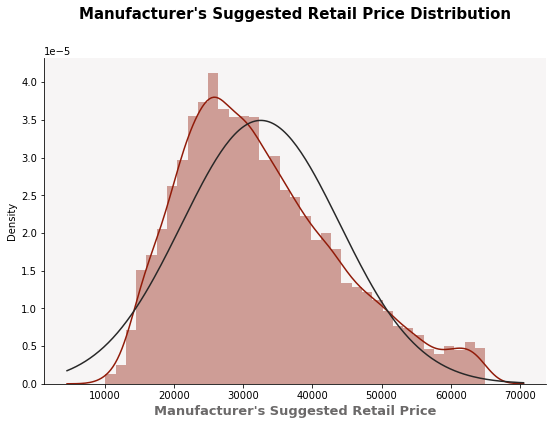

In [33]:
# MSRP distburion for new data
fig, ax = plt.subplots(figsize=(9, 6))
sns.distplot(dfnew['MSRP'], fit=norm, color = "#911B09")
ax.set_xlabel("Manufacturer's Suggested Retail Price", color='#6B6969', fontsize=13, weight = 'bold')
ax.set_title("Manufacturer's Suggested Retail Price Distribution",
             fontsize=15, weight='bold', x= 0.5, y = 1.1)
ax.set_facecolor('#F7F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

<div class="alert alert-block alert-warning">
Now, the distrbution of MSRP is very close to normal.

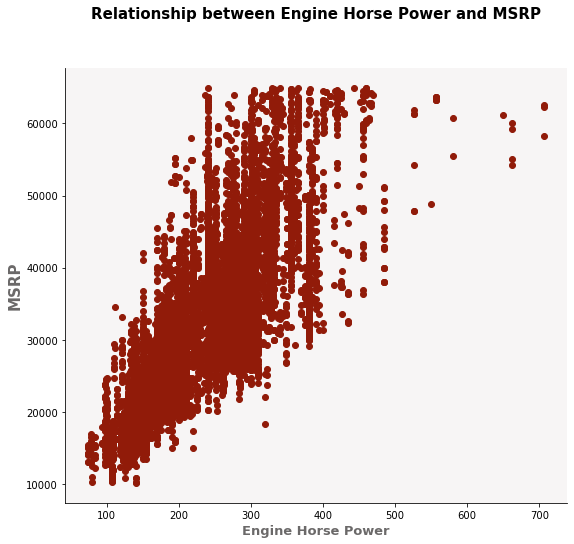

In [34]:
# Scatter plot to visualize relationship
# between Engine Horse Power and MSRP.

fig, ax = plt.subplots(figsize=(9, 8))
plt.scatter(x=dfnew['Engine HP'], y=dfnew.MSRP, color = '#911B09')
ax.set_xlabel("Engine Horse Power", color='#6B6969', fontsize=13, weight = 'bold')
ax.set_ylabel("MSRP", color='#6B6969', fontsize=15, weight = 'bold')
ax.set_title("Relationship between Engine Horse Power and MSRP",
             fontsize=15, weight='bold', x= 0.5, y = 1.1)
ax.set_facecolor('#F7F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

<div class="alert alert-block alert-warning">
Looks like Engine horsepower has a strong positive linear relationship with selling price of the car. There are some observations with engine horsepower greater than 700 taht do not follow the trend. These observations could be influential points but we care more about how much they influence selling price of the car. We will investigate on this further in our regression analysis section. Based on the seriousness of the influence, we can decide if we should keep or drop the observations.

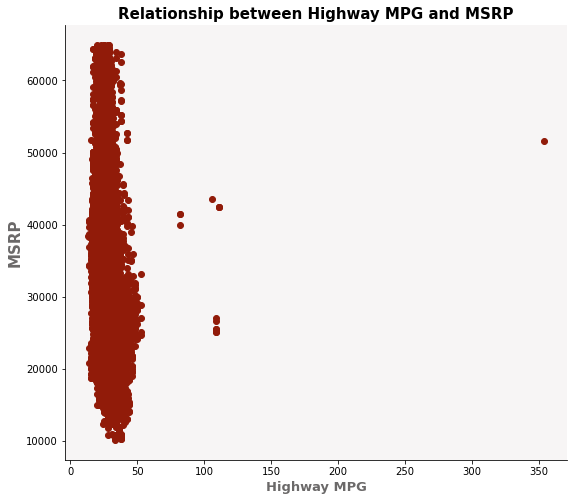

In [35]:
# Scatter plot to visualize relationship
# between Highway MPG and MSRP.

fig, ax = plt.subplots(figsize=(9, 8))
plt.scatter(x=dfnew['highway MPG'], y=dfnew.MSRP, color = '#911B09')
ax.set_xlabel("Highway MPG", color='#6B6969', fontsize=13, weight = 'bold')
ax.set_ylabel("MSRP", color='#6B6969', fontsize=15, weight = 'bold')
ax.set_title("Relationship between Highway MPG and MSRP",
             fontsize=15, weight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('#F7F5F5')
plt.show()

<div class="alert alert-block alert-warning">
Surprisingly, there's not much of a clear relationship between highway miles per gallon and the selling price of the car. It looks like the highway MPG lies withing the same range for all MSRP values 

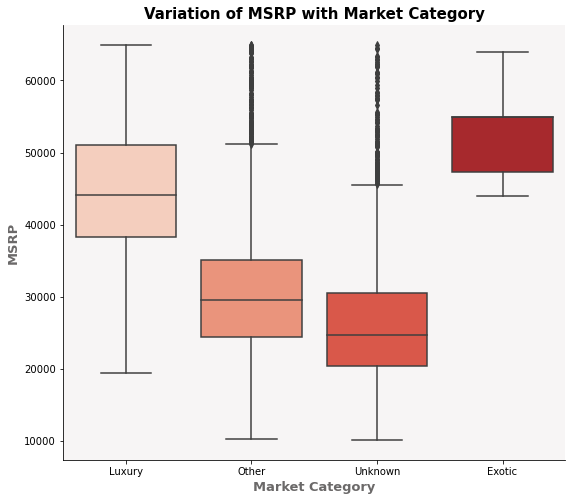

In [36]:
# Box plot to visualize relationship
# between Market Category and MSRP.

f, ax = plt.subplots(figsize=(9, 8))
fig = sns.boxplot(x='Market Category', y="MSRP", data=dfnew, palette="Reds")
ax.set_xlabel("Market Category", color='#6B6969', fontsize=13, weight = 'bold')
ax.set_ylabel("MSRP", color='#6B6969', fontsize=13, weight = 'bold')

ax.set_title("Variation of MSRP with Market Category", fontsize=15, weight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('#F7F5F5')
plt.show()

<div class="alert alert-block alert-warning">
This is very much in line with what we had expected. Luxury and exotic cars have higher selling price.

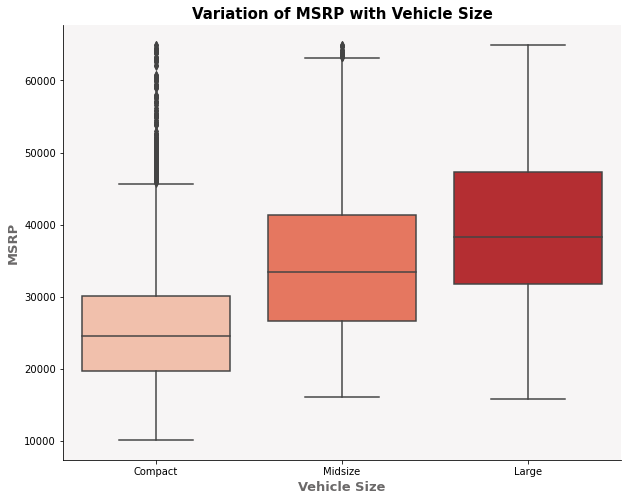

In [38]:
# Box plot to visualize relationship
# between Vehicle Size and MSRP.

f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x='Vehicle Size', y="MSRP", data=dfnew, palette='Reds')
ax.set_xlabel("Vehicle Size",  color='#6B6969', fontsize=13, weight = 'bold')
ax.set_ylabel("MSRP",  color='#6B6969', fontsize=13, weight = 'bold')
ax.set_title("Variation of MSRP with Vehicle Size", fontsize=15, weight='bold')
ax.set_facecolor('#F7F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

<div class="alert alert-block alert-warning">
As expected, we see that as vehicle size increases, the selling price also increases.

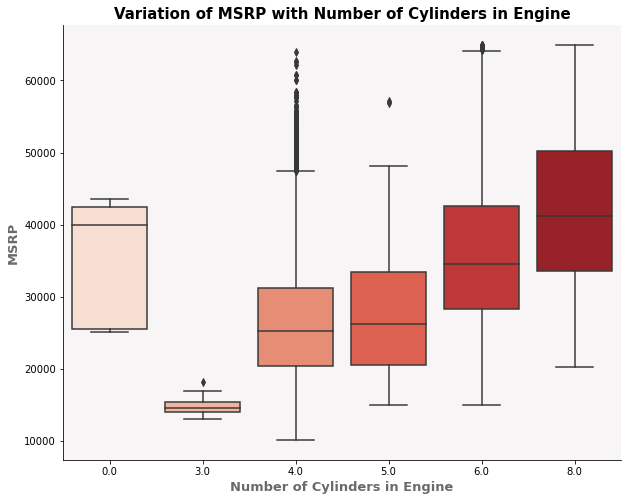

In [40]:
# Box plot to visualize relationship
# between Number of Cylinders and MSRP.

f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x='Engine Cylinders', y="MSRP", data=dfnew, palette='Reds')
ax.set_xlabel("Number of Cylinders in Engine", color='#6B6969', fontsize=13, weight = 'bold')
ax.set_ylabel("MSRP",  color='#6B6969', fontsize=13, weight = 'bold')
ax.set_title("Variation of MSRP with Number of Cylinders in Engine", fontsize=15, weight='bold')
ax.set_facecolor('#F7F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

<div class="alert alert-block alert-warning">
As expected, we see that as the number of cylinders increases, the selling price also increases, except for vehicles with less than 3 cylinders.

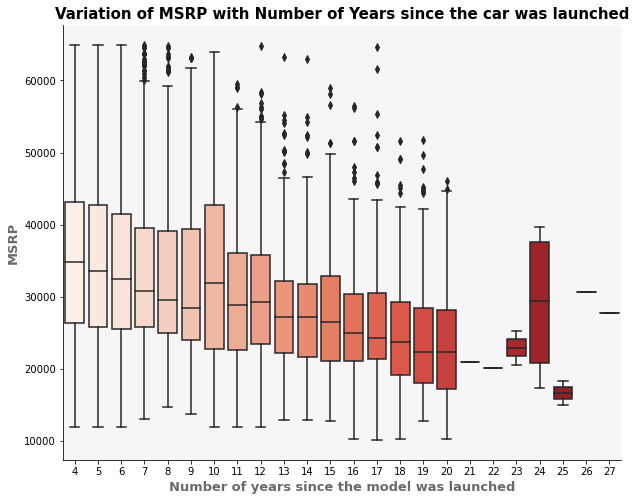

In [41]:
# Box plot to visualize relationship
# between Year and MSRP.

f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x='Year', y="MSRP", data=dfnew, palette='Reds')
ax.set_xlabel("Number of years since the model was launched", color='#6B6969', fontsize=13, weight = 'bold')
ax.set_ylabel("MSRP", color='#6B6969', fontsize=13, weight = 'bold')
ax.set_title("Variation of MSRP with Number of Years since the car was launched", fontsize=15, weight='bold')
ax.set_facecolor('#F7F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

<div class="alert alert-block alert-warning">
Surprisingly, there's not much of a clear relationship between 'Year' and the selling price of the car.

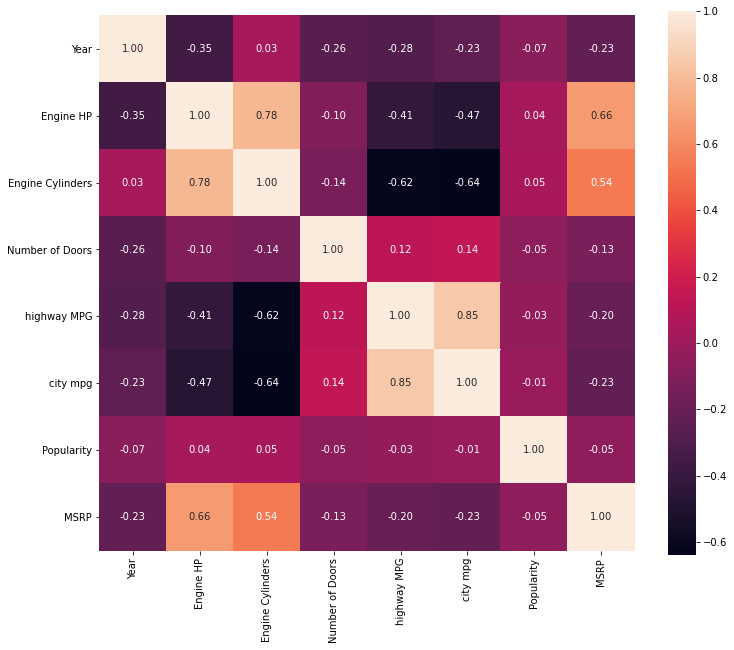

In [43]:
fig = plt.figure(figsize=(12,10))
corrmat = df.corr()
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 10})
plt.show()

<div class="alert alert-block alert-warning">
As we had observed above, 'Engine HP' has a good correlation with Sale Price. In addition, we see that 'Highway MPG' is storngly correlated to 'City MPG'. These columns will provide same kind of information and induce multicollinearity. Hence, it would be better to drop one of these columns.  

In [44]:
dfnew = dfnew.drop(columns=['city mpg']).copy()

In [45]:
df = dfnew.rename(columns={"Engine Fuel Type": "Engine_Fuel_Type",
                        "Engine HP":"Engine_HP",
                        "Engine Cylinders":"Engine_Cylinders",
                       "Transmission Type":"Transmission_Type",
                        "Number of Doors":"Number_of_Doors",
                        "Market Category":"Market_Category",
                        "Vehicle Size":"Vehicle_Size",
                        "Vehicle Style":"Vehicle_Style",
                        "highway MPG":"highway_MPG"})
df.head(5)

,Make,Year,Engine_Fuel_Type,Engine_HP,Engine_Cylinders,Transmission_Type,Driven_Wheels,Number_of_Doors,Market_Category,Vehicle_Size,Vehicle_Style,highway_MPG,Popularity,MSRP
0,BMW,10,premium,335.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,coupe,26,3916,46135
1,BMW,10,premium,300.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,convertible,28,3916,40650
2,BMW,10,premium,300.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,coupe,28,3916,36350
3,BMW,10,premium,230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,coupe,28,3916,29450
4,BMW,10,premium,230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,convertible,28,3916,34500


### Before fitting the model
pick all predictors of interest and check Multicollinearity

In [46]:
# VIF

# Categorical - Engine Cylinders, Number of Doors
y, X = dmatrices('MSRP~Make+Year+Engine_Fuel_Type+Engine_HP+C(Engine_Cylinders)+Transmission_Type+Driven_Wheels+C(Number_of_Doors)+Market_Category+Vehicle_Size+Vehicle_Style+highway_MPG+Popularity', data=df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
pd.set_option('display.max_rows', None) 
print(vif)

    VIF Factor                            features
0     0.000000                           Intercept
1          inf                  Make[T.Alfa Romeo]
2          inf                        Make[T.Audi]
3          inf                         Make[T.BMW]
4          inf                       Make[T.Buick]
5          inf                    Make[T.Cadillac]
6          inf                   Make[T.Chevrolet]
7          inf                    Make[T.Chrysler]
8          inf                       Make[T.Dodge]
9          inf                        Make[T.FIAT]
10         inf                        Make[T.Ford]
11         inf                         Make[T.GMC]
12         inf                     Make[T.Genesis]
13         inf                      Make[T.HUMMER]
14         inf                       Make[T.Honda]
15         inf                     Make[T.Hyundai]
16         inf                    Make[T.Infiniti]
17         inf                         Make[T.Kia]
18         inf                 

<div class="alert alert-block alert-warning">
We identify 'Engine_Fuel_Type','Engine_Cylinders', 'Market_Category', 'Make' and 'Popularity' as varaibles that is causing critical the multicolinearity problem. Since they have high VIF >10, we can consider delete them. 

In [47]:
y, X_new = dmatrices('MSRP~Year+Engine_HP+Transmission_Type+Driven_Wheels+C(Number_of_Doors)+Vehicle_Size+Vehicle_Style+highway_MPG', data=df, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns
print(vif)

    VIF Factor                            features
0   153.246883                           Intercept
1     4.782514      Transmission_Type[T.AUTOMATIC]
2     1.339534   Transmission_Type[T.DIRECT_DRIVE]
3     4.503630         Transmission_Type[T.MANUAL]
4     2.086016   Driven_Wheels[T.four wheel drive]
5     2.300171  Driven_Wheels[T.front wheel drive]
6     2.372026   Driven_Wheels[T.rear wheel drive]
7     3.209597           C(Number_of_Doors)[T.3.0]
8     3.554267           C(Number_of_Doors)[T.4.0]
9     2.391537               Vehicle_Size[T.Large]
10    2.043379             Vehicle_Size[T.Midsize]
11    1.148740      Vehicle_Style[T.cargo minivan]
12    1.639499          Vehicle_Style[T.cargo van]
13    2.317652        Vehicle_Style[T.convertible]
14    1.048705    Vehicle_Style[T.convertible suv]
15    2.842711              Vehicle_Style[T.coupe]
16    2.804397          Vehicle_Style[T.hatchback]
17    1.660354  Vehicle_Style[T.passenger minivan]
18    2.378229      Vehicle_Sty

### Fit the initial model 1

In [48]:

model =smf.ols('MSRP~Year+Engine_HP+Transmission_Type+Driven_Wheels+C(Number_of_Doors)+Vehicle_Size+Vehicle_Style+highway_MPG', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSRP   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     933.5
Date:                Fri, 15 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:35:23   Log-Likelihood:                -91139.
No. Observations:                8992   AIC:                         1.823e+05
Df Residuals:                    8967   BIC:                         1.825e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           5416.4171    797.906      6.788      0.000    3852.339    6980.495
Transmission_Type[T.AUTOMATIC]     -2284.0080    333.385     -6.851      0.000   -2937.519   -1630.497
Transmission_Type[T.DIRECT_DRIVE]  -2394.5324   1828.007     -1.310      0.190   -5977.844    1188.779
Transmission_Type[T.MANUAL]        -5156.0752    350.930    -14.693      0.000   -5843.979   -4468.172
Driven_Wheels[T.four wheel drive]   -640.6020    295.202     -2.170      0.030   -1219.265     -61.939
Driven_Wheels[T.front wheel drive] -5638.8430    196.540    -28.691      0.000   -6024.106   -5253.580
Driven_Wheels[T.rear wheel drive]  -2482.6421    235.457    -10.544      0.000   -2944.191   -2021.093
C(Number_of_Doors)[T.3.0]           -152.6572    713.552     -0.214      0.831   -1551.383    1246.068
C(Number_of_Doors)[T.4.0]            290.4232    295.193      0.984      0.325    -288.223     869.069
Vehicle_Size[T.Large]               2121.6594    245.262      8.651      0.000    1640.889    2602.430
Vehicle_Size[T.Midsize]              520.4524    187.941      2.769      0.006     152.045     888.860
Vehicle_Style[T.cargo minivan]      4503.1680    828.231      5.437      0.000    2879.647    6126.689
Vehicle_Style[T.cargo van]          1533.1406   1121.058      1.368      0.171    -664.390    3730.671
Vehicle_Style[T.convertible]        1.257e+04    444.468     28.275      0.000    1.17e+04    1.34e+04
Vehicle_Style[T.convertible suv]    9132.5786   1476.759      6.184      0.000    6237.793     1.2e+04
Vehicle_Style[T.coupe]              4898.7643    430.523     11.379      0.000    4054.840    5742.688
Vehicle_Style[T.hatchback]          5052.5683    347.312     14.548      0.000    4371.758    5733.379
Vehicle_Style[T.passenger minivan]  6447.1662    434.813     14.827      0.000    5594.834    7299.498
Vehicle_Style[T.passenger van]      4632.4882    934.101      4.959      0.000    2801.436    6463.540
Vehicle_Style[T.sedan]              6354.7036    301.521     21.076      0.000    5763.654    6945.753
Vehicle_Style[T.suv]                6801.3982    268.083     25.370      0.000    6275.894    7326.902
Vehicle_Style[T.wagon]              6588.9032    383.019     17.203      0.000    5838.097    7339.709
Year                                -225.3057     17.879    -12.601      0.000    -260.353    -190.258
Engine_HP                            103.0281      1.418     72.651      0.000     100.248     105.808
highway_MPG                          151.3486     14.604     10.363      0.000     122.721     179.976
==============================================================================
Omnibus:                      487.483   Durbin-Watson:                   0.746
Prob(Omnibus):                  0.000   J

### Check influential points

In [49]:
# Inluential points
infl = model.get_influence()

#threshold externally studentized residuals

n=8992
p=25
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
print('Index:\n',df.index[atyp_stud])

Index:
 Int64Index([   66,    69,    72,    73,    78,    79,    83,   474,   476,
              477,
            ...
            11844, 11855, 11860, 11886, 11889, 11890, 11892, 11895, 11907,
            11910],
           dtype='int64', length=525)


In [50]:
#Cook's distance
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
print('Index:\n',df.index[atyp_cook])

Index:
 Int64Index([  474,   476,   477,   505,   507,   509,   511,   512,   513,
              517,
            ...
            11838, 11842, 11844, 11886, 11889, 11890, 11892, 11895, 11907,
            11910],
           dtype='int64', length=365)


In [51]:
c = df.index[atyp_stud]
d = df.index[atyp_cook]
cd = d.union(c)
cd

Int64Index([   66,    69,    72,    73,    78,    79,    83,   474,   476,
              477,
            ...
            11844, 11855, 11860, 11886, 11889, 11890, 11892, 11895, 11907,
            11910],
           dtype='int64', length=608)

<div class="alert alert-block alert-warning">
Above are the index of observation numbers that were identified as influential points by threshold externally studentized residuals or Cook's distance. We don't simply delete the influential points. Rather, we report them and present analysis with and without the influential points. 

### Check heteroscedasticity

Text(0.5, 1.0, 'Fitted Values vs. Residuals')

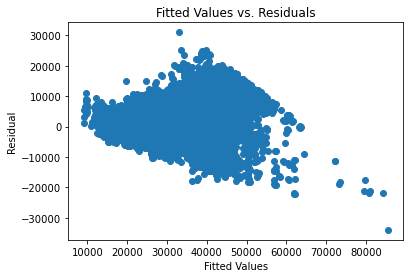

In [52]:
#Fitted Values vs. Residuals Plot
p = model.fittedvalues
res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

<div class="alert alert-block alert-warning">
There's obvious change in bandwidth with hat_y, suggesting heteroscedasticity problem.

In [53]:
#Breusch-Pagan for Heteroskedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['BP Statistic', 'BP-Test p-value']
print(dict(zip(labels, bp_test)))
# Heteroskedasticity exists

{'BP Statistic': 1691.702170783777, 'BP-Test p-value': 0.0}


<div class="alert alert-block alert-warning">
Through Breusch-Pagen test, we found that the p-value < 0.05. Also, through the residual plot, we observe change of bandwidth with x intervals. We would use natual-log transformation on y as the residul plot doesn't change proportionally with hat_y.

### Check normality

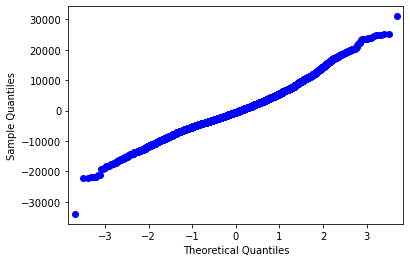

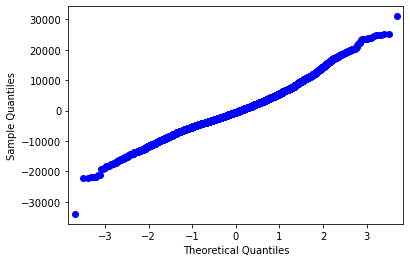

In [54]:
# qq plot
sm.qqplot(model.resid)

<div class="alert alert-block alert-warning">
 The QQ plots are approx. diagonal, showing that the distribution of the data might not exist normality problem. It's normally distributed. However, there are weird points on two sides of the QQ plot. We could use natural-log transformation on y.

(array([1.000e+00, 7.000e+00, 6.100e+01, 5.880e+02, 3.183e+03, 3.571e+03,
        1.209e+03, 2.920e+02, 7.400e+01, 6.000e+00]),
 array([-33982.40797804, -27478.72543405, -20975.04289006, -14471.36034607,
         -7967.67780208,  -1463.99525808,   5039.68728591,  11543.3698299 ,
         18047.05237389,  24550.73491788,  31054.41746187]),
 <BarContainer object of 10 artists>)

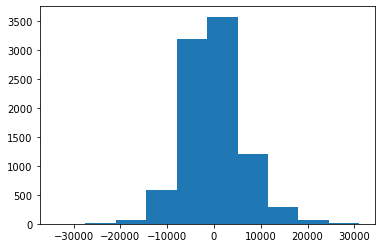

In [55]:
#histogram of residual to observe the shape/skewness
plt.hist(model.resid)

<div class="alert alert-block alert-warning">
The skewness of residual is approx. 0, showing approx. symmtry.

In [56]:
#Jarque-Bera test on the residuals
jb_test = jarque_bera(model.resid)
labels = ['JB Statistic', 'JB-Test p-value']
print(dict(zip(labels, jb_test)))

{'JB Statistic': 819.5671048414231, 'JB-Test p-value': 0.0}


<div class="alert alert-block alert-warning">
 p-val < 0.05, reject H0. There's skewness (normality) problem for this dataset. We could use natural-log transformation on y. However, since Jarque-Bera is sensitive to outliers, outliers might cause the rejection.

### Delete influential points, take natural log on y

In [57]:
df_new = df.drop(cd)
df_new['log_MSRP']=np.log(df_new['MSRP']+1)

### Fit the initial model 2

In [58]:
model_1 =smf.ols('log_MSRP~Year+Engine_HP+Engine_Cylinders+Transmission_Type+Driven_Wheels+Number_of_Doors+Vehicle_Size+Vehicle_Style+highway_MPG', data=df_new).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_MSRP   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     1460.
Date:                Fri, 15 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:37:57   Log-Likelihood:                 4080.2
No. Observations:                8384   AIC:                            -8110.
Df Residuals:                    8359   BIC:                            -7934.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              9.4921      0.030    320.384      0.000       9.434       9.550
Transmission_Type[T.AUTOMATIC]        -0.1039      0.008    -12.497      0.000      -0.120      -0.088
Transmission_Type[T.DIRECT_DRIVE]     -0.1082      0.106     -1.023      0.306      -0.316       0.099
Transmission_Type[T.MANUAL]           -0.2125      0.009    -24.308      0.000      -0.230      -0.195
Driven_Wheels[T.four wheel drive]  -1.447e-05      0.008     -0.002      0.999      -0.015       0.015
Driven_Wheels[T.front wheel drive]    -0.1502      0.005    -29.430      0.000      -0.160      -0.140
Driven_Wheels[T.rear wheel drive]     -0.0698      0.006    -11.280      0.000      -0.082      -0.058
Vehicle_Size[T.Large]                  0.0640      0.006      9.867      0.000       0.051       0.077
Vehicle_Size[T.Midsize]                0.0676      0.005     14.221      0.000       0.058       0.077
Vehicle_Style[T.cargo minivan]         0.1100      0.020      5.369      0.000       0.070       0.150
Vehicle_Style[T.cargo van]             0.0682      0.023      2.943      0.003       0.023       0.114
Vehicle_Style[T.convertible]           0.3291      0.012     28.572      0.000       0.307       0.352
Vehicle_Style[T.convertible suv]       0.1789      0.086      2.070      0.038       0.009       0.348
Vehicle_Style[T.coupe]                 0.0706      0.011      6.173      0.000       0.048       0.093
Vehicle_Style[T.hatchback]             0.0730      0.009      7.949      0.000       0.055       0.091
Vehicle_Style[T.passenger minivan]     0.1827      0.011     16.876      0.000       0.161       0.204
Vehicle_Style[T.passenger van]         0.1546      0.017      9.190      0.000       0.122       0.188
Vehicle_Style[T.sedan]                 0.0846      0.008     10.213      0.000       0.068       0.101
Vehicle_Style[T.suv]                   0.1398      0.007     20.226      0.000       0.126       0.153
Vehicle_Style[T.wagon]                 0.1391      0.010     14.070      0.000       0.120       0.158
Year                                  -0.0054      0.001     -9.411      0.000      -0.006      -0.004
Engine_HP                              0.0037   5.14e-05     71.118      0.000       0.004       0.004
Engine_Cylinders                      -0.0184      0.003     -6.787      0.000      -0.024      -0.013
Number_of_Doors                       -0.0014      0.004     -0.393      0.694      -0.009       0.006
highway_MPG                            0.0064      0.001     10.587      0.000       0.005       0.008
==============================================================================
Omnibus:                       52.952   Durbin-Watson:                   0.925
Prob(Omnibus):                  0.000   J

### Check influential points

In [59]:
# Inluential points
infl = model_1.get_influence()

#threshold externally studentized residuals
import scipy
n=8384
p=25
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
print('Index:\n',df_new.index[atyp_stud])

Index:
 Int64Index([  144,   146,   153,   159,   161,   164,   439,   518,   521,
              522,
            ...
            11698, 11706, 11713, 11744, 11748, 11752, 11753, 11759, 11764,
            11782],
           dtype='int64', length=372)


In [60]:
#Cook's distance
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
print('Index:\n',df_new.index[atyp_cook])

Index:
 Int64Index([  135,   140,   146,   153,   161,   164,   439,   518,   521,
              526,
            ...
            11427, 11428, 11429, 11435, 11440, 11446, 11638, 11894, 11897,
            11901],
           dtype='int64', length=283)


In [61]:
c = df_new.index[atyp_stud]
d = df_new.index[atyp_cook]
cd = d.union(c)
cd

Int64Index([  135,   140,   144,   146,   153,   159,   161,   164,   439,
              518,
            ...
            11744, 11748, 11752, 11753, 11759, 11764, 11782, 11894, 11897,
            11901],
           dtype='int64', length=466)

<div class="alert alert-block alert-warning">
Above are the index of observation numbers that were identified as influential points by threshold externally studentized residuals or Cook's distance. We don't simply delete the influential points. Rather, we report them and present analysis with and without the influential points. 

### Check heteroscedasticity

Text(0.5, 1.0, 'Fitted Values vs. Residuals after log transformation on y')

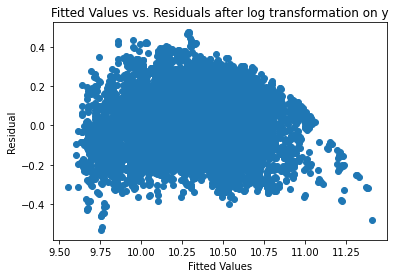

In [62]:
p1 = model_1.fittedvalues
res1 = model_1.resid
plt.scatter(p1,res1)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals after log transformation on y")

<div class="alert alert-block alert-warning">
The heteroscedasticity improved, with similar bandwidth.

In [63]:
#Breusch-Pagan for heteroscedasticity
bp_test = het_breuschpagan(model_1.resid, model_1.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))
# Heteroskedasticity exists

{'LM Statistic': 312.7388830067124, 'LM-Test p-value': 4.524654900047722e-52}


<div class="alert alert-block alert-warning">
Through Breusch-Pagen test, we found that the p-value < 0.05. There might still be heteroscedasticity problem. However, since it is very sensitive to outliers, the exsitence of outliers might cause the rejection.

### Check normality

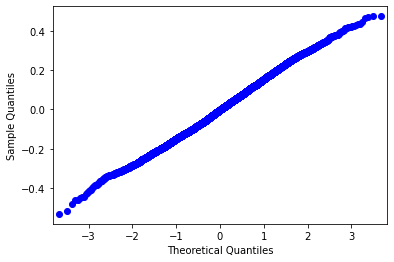

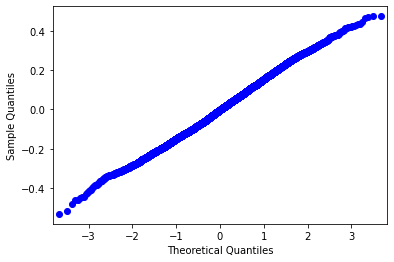

In [64]:
# qq plot
sm.qqplot(model_1.resid)

<div class="alert alert-block alert-warning">
 The QQ plots are diagonal, showing that the distribution of the data might not exist normality problem. It's normally distributed.

(array([   8.,   55.,  407., 1189., 1985., 2107., 1527.,  802.,  264.,
          40.]),
 array([-0.5322566 , -0.43155165, -0.33084671, -0.23014176, -0.12943682,
        -0.02873187,  0.07197307,  0.17267802,  0.27338296,  0.37408791,
         0.47479285]),
 <BarContainer object of 10 artists>)

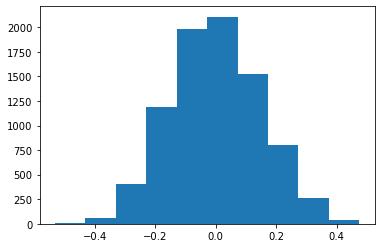

In [65]:
#histogram of residual to observe the shape/skewness
plt.hist(model_1.resid)

<div class="alert alert-block alert-warning">
    By looking at the histogram of residuals, we see that it is approx. symmetric, showing skewness approx. = 0. There's no voilation of Normality

In [66]:
#Jarque-Bera test on the residuals
jb_test = jarque_bera(model_1.resid)
labels = ['JB Statistic', 'JB-Test p-value']
print(dict(zip(labels, jb_test)))

{'JB Statistic': 41.173983947293266, 'JB-Test p-value': 1.1459957427462086e-09}


<div class="alert alert-block alert-warning">
 p-val < 0.05, reject H0. There's skewness (normality) problem for this dataset. However, since Jarque-Bera is sensitive to outliers, outliers might cause the rejection.

### Model 1 : 
log_MSRP~Year+Engine_HP+Engine_Cylinders+Transmission_Type+Driven_Wheels+Number_of_Doors+Vehicle_Size+Vehicle_Style+highway_MPG

In [67]:
# Drop the influential points
df_final = df_new.drop(cd)

In [68]:
model_1 =smf.ols('log_MSRP~Year+Engine_HP+Engine_Cylinders+Transmission_Type+Driven_Wheels+Number_of_Doors+Vehicle_Size+Vehicle_Style+highway_MPG', data=df_final).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_MSRP   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     1799.
Date:                Fri, 15 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:40:16   Log-Likelihood:                 4851.8
No. Observations:                7918   AIC:                            -9654.
Df Residuals:                    7893   BIC:                            -9479.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              9.5224      0.027    347.632      0.000       9.469       9.576
Transmission_Type[T.AUTOMATIC]        -0.1057      0.007    -14.116      0.000      -0.120      -0.091
Transmission_Type[T.DIRECT_DRIVE]     -0.0948      0.093     -1.016      0.310      -0.278       0.088
Transmission_Type[T.MANUAL]           -0.2117      0.008    -26.800      0.000      -0.227      -0.196
Driven_Wheels[T.four wheel drive]     -0.0022      0.007     -0.321      0.748      -0.016       0.011
Driven_Wheels[T.front wheel drive]    -0.1452      0.005    -31.310      0.000      -0.154      -0.136
Driven_Wheels[T.rear wheel drive]     -0.0708      0.006    -12.610      0.000      -0.082      -0.060
Vehicle_Size[T.Large]                  0.0565      0.006      9.604      0.000       0.045       0.068
Vehicle_Size[T.Midsize]                0.0705      0.004     16.268      0.000       0.062       0.079
Vehicle_Style[T.cargo minivan]         0.1197      0.019      6.144      0.000       0.082       0.158
Vehicle_Style[T.cargo van]             0.0781      0.023      3.342      0.001       0.032       0.124
Vehicle_Style[T.convertible]           0.3059      0.010     29.340      0.000       0.285       0.326
Vehicle_Style[T.convertible suv]       0.1571      0.132      1.194      0.233      -0.101       0.415
Vehicle_Style[T.coupe]                 0.0640      0.010      6.131      0.000       0.044       0.084
Vehicle_Style[T.hatchback]             0.0586      0.008      7.060      0.000       0.042       0.075
Vehicle_Style[T.passenger minivan]     0.1800      0.010     18.134      0.000       0.161       0.199
Vehicle_Style[T.passenger van]         0.1451      0.015      9.709      0.000       0.116       0.174
Vehicle_Style[T.sedan]                 0.0660      0.008      8.747      0.000       0.051       0.081
Vehicle_Style[T.suv]                   0.1241      0.006     19.930      0.000       0.112       0.136
Vehicle_Style[T.wagon]                 0.1202      0.009     13.418      0.000       0.103       0.138
Year                                  -0.0052      0.001     -9.881      0.000      -0.006      -0.004
Engine_HP                              0.0038    4.8e-05     79.602      0.000       0.004       0.004
Engine_Cylinders                      -0.0251      0.003    -10.006      0.000      -0.030      -0.020
Number_of_Doors                       -0.0027      0.003     -0.809      0.418      -0.009       0.004
highway_MPG                            0.0057      0.001     10.028      0.000       0.005       0.007
==============================================================================
Omnibus:                      372.295   Durbin-Watson:                   1.047
Prob(Omnibus):                  0.000   J

Text(0.5, 1.0, 'Fitted Values vs. Residuals after log transformation on y')

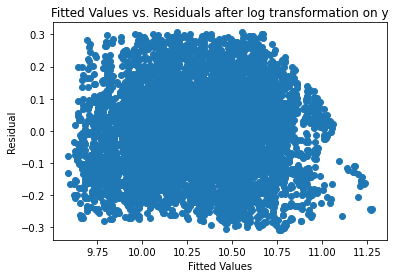

In [69]:
p2 = model_1.fittedvalues
res2 = model_1.resid
plt.scatter(p2,res2)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals after log transformation on y")

In [70]:
#Breusch-Pagan for heteroscedasticity
bp_test = het_breuschpagan(model_1.resid, model_1.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))
# Heteroskedasticity exists

{'LM Statistic': 211.71226534715248, 'LM-Test p-value': 5.560556622175274e-32}


<div class="alert alert-block alert-warning">
Compared with initial model2, R2 is higher after dropping the  influential points. And the heteroscedasticity much improved, with very similar bandwidth. The p-value of BP test still smaller than 0.05. We think it's because the BP being too sensitive to the points on the bottom right. We can move forward to the model selection.

### Stepwise Model Selection (In R)

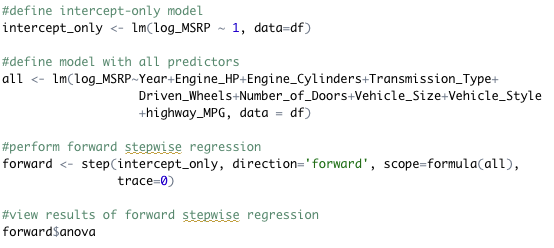

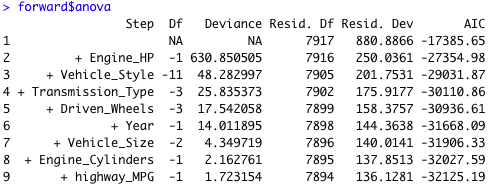

<div class="alert alert-block alert-warning">
Due to the result of the stepwise model selection, we can see 'Number_of_Doors' is not chosen. It is consistant with the Anova test of Model_1(full), in which the p-value of t-test of 'Number_of_Doors' is 0.418. Therefore, we can fit the model of log_MSRP against the 8 chosen variables.

### Model_2

In [71]:
model_3 =smf.ols('log_MSRP~Year+Engine_HP+Engine_Cylinders+Transmission_Type+Driven_Wheels+Vehicle_Size+Vehicle_Style+highway_MPG', data=df_final).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_MSRP   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     1878.
Date:                Fri, 15 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:40:31   Log-Likelihood:                 4851.4
No. Observations:                7918   AIC:                            -9655.
Df Residuals:                    7894   BIC:                            -9487.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              9.5144      0.026    372.562      0.000       9.464       9.564
Transmission_Type[T.AUTOMATIC]        -0.1061      0.007    -14.215      0.000      -0.121      -0.092
Transmission_Type[T.DIRECT_DRIVE]     -0.0948      0.093     -1.016      0.310      -0.278       0.088
Transmission_Type[T.MANUAL]           -0.2118      0.008    -26.807      0.000      -0.227      -0.196
Driven_Wheels[T.four wheel drive]     -0.0022      0.007     -0.312      0.755      -0.016       0.011
Driven_Wheels[T.front wheel drive]    -0.1451      0.005    -31.300      0.000      -0.154      -0.136
Driven_Wheels[T.rear wheel drive]     -0.0705      0.006    -12.585      0.000      -0.081      -0.060
Vehicle_Size[T.Large]                  0.0571      0.006      9.750      0.000       0.046       0.069
Vehicle_Size[T.Midsize]                0.0707      0.004     16.336      0.000       0.062       0.079
Vehicle_Style[T.cargo minivan]         0.1194      0.019      6.128      0.000       0.081       0.158
Vehicle_Style[T.cargo van]             0.0796      0.023      3.418      0.001       0.034       0.125
Vehicle_Style[T.convertible]           0.3103      0.009     34.731      0.000       0.293       0.328
Vehicle_Style[T.convertible suv]       0.1607      0.132      1.222      0.222      -0.097       0.419
Vehicle_Style[T.coupe]                 0.0685      0.009      7.729      0.000       0.051       0.086
Vehicle_Style[T.hatchback]             0.0596      0.008      7.259      0.000       0.044       0.076
Vehicle_Style[T.passenger minivan]     0.1793      0.010     18.141      0.000       0.160       0.199
Vehicle_Style[T.passenger van]         0.1467      0.015      9.918      0.000       0.118       0.176
Vehicle_Style[T.sedan]                 0.0652      0.007      8.721      0.000       0.051       0.080
Vehicle_Style[T.suv]                   0.1234      0.006     20.017      0.000       0.111       0.135
Vehicle_Style[T.wagon]                 0.1193      0.009     13.427      0.000       0.102       0.137
Year                                  -0.0052      0.001     -9.848      0.000      -0.006      -0.004
Engine_HP                              0.0038    4.8e-05     79.608      0.000       0.004       0.004
Engine_Cylinders                      -0.0253      0.002    -10.124      0.000      -0.030      -0.020
highway_MPG                            0.0057      0.001      9.996      0.000       0.005       0.007
==============================================================================
Omnibus:                      374.536   Durbin-Watson:                   1.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.255
Skew:                           0.068   Prob(JB):                

<div class="alert alert-block alert-warning">
In model 2, we dropped predictor "Number_of_doors". Adj. R-squared is still 0.845, while the F-statistic become bigger. p-value of t-test of all the other variables are all much smaller than 0.05(For the category variables, each of them at least has 2 significant dummy variables). Therefore, we think this model performs well.